In [1]:
import pickle

from src.models import HLGC
from src.data import Newsgroups

In [2]:
#data = pickle.load(open('data/cifar100-resnet152.pickle', 'rb'))
data = pickle.load(open('data/20newsgroups.pickle', 'rb'))

In [3]:
hparams = {
    'n_features' : len(data['train']['features'][0]),
    'hidden_dim' : 128,
    'latent_dims' : [50, 50, 50, 50, 50],
    'batch_size' : 32,
    'lr' : 0.001,
    'dropout' : 0.5,
    'n_epochs' : 25,
    'early_stopping_epochs' : 5,
    'latent_loss_weight' : 1.0,
    'recon_loss_weight' : 1.0,
    'l1_lambda' : 0.01, 
    'val_split' : 0.1, 
    'display_interval' : 200
}

In [4]:
model = HLGC(
    len(data['flat_label_dict']), hparams['n_features'], hparams['latent_dims'], hidden_dim=hparams['hidden_dim'], 
    dropout_rate=hparams['dropout'], batch_size=hparams['batch_size'], lr=hparams['lr'], 
    n_epochs=hparams['n_epochs'], class_weights=data['class_weights'], recon_loss_weight=hparams['recon_loss_weight'], 
    latent_loss_weight=hparams['latent_loss_weight'], 
    l1_lambda=hparams['l1_lambda'], display_interval=hparams['display_interval'], 
    early_stopping_epochs=hparams['early_stopping_epochs'], label_dict=data['flat_label_dict']
)

No validation data provided, using 10.0% of train data
[0,     1] loss - (total : 23.049843, clf : 2.987758, support : 3.008975, recon : 3.901904, latent : 2.996255), acc - (clf : 0.093750, recon : 0.012500)
[0,   200] loss - (total : 6.875712, clf : 1.734422, support : 2.428573, recon : 0.277501, latent : 2.163869), acc - (clf : 0.812500, recon : 0.812500)
[ Eval ] loss - (total : 5.520743, clf : 1.000095, support : 2.090982, recon : 0.229947, latent : 1.873678), acc - (clf : 0.889576, support : 0.240283, recon : 0.858304)
comp.graphics : [5, 36, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 14, 11, 46, 17]
comp.windows.x : [5, 14, 11, 46, 17]
misc.forsale : [5, 36, 11, 46, 17]
rec.autos : [5, 36, 11, 46, 17]
sci.electronics : [5, 36, 11, 46, 17]
sci.med : [5, 14, 44, 46, 17]
sci.space : [5, 14, 11, 46, 17]
talk.politics.misc : [5, 14, 19, 46, 24]
-----
comp.sys.mac.hardware : [20, 36, 11, 46, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec

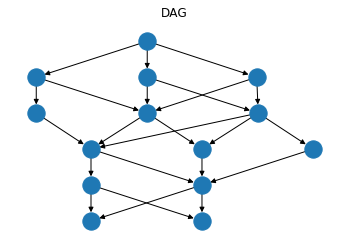

[1,   400] loss - (total : 4.835825, clf : 0.650322, support : 1.969591, recon : 0.203299, latent : 1.656506), acc - (clf : 0.968750, recon : 0.906250)
[1,   600] loss - (total : 4.247532, clf : 0.409095, support : 1.705855, recon : 0.154893, latent : 1.612288), acc - (clf : 0.937500, recon : 0.912500)
[ Eval ] loss - (total : 4.105359, clf : 0.465133, support : 1.682012, recon : 0.134870, latent : 1.452146), acc - (clf : 0.901060, support : 0.367491, recon : 0.934099)
comp.graphics : [5, 36, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 46, 17]
comp.sys.mac.hardware : [5, 23, 11, 46, 17]
comp.windows.x : [5, 23, 11, 46, 17]
misc.forsale : [5, 36, 11, 46, 17]
rec.autos : [5, 36, 11, 46, 17]
rec.motorcycles : [5, 36, 11, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 14, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
talk.politics.guns 

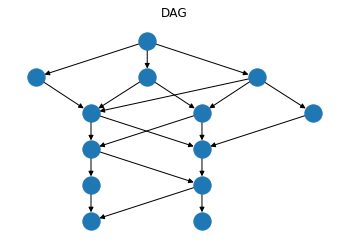

[2,   800] loss - (total : 3.853498, clf : 0.280388, support : 1.679177, recon : 0.033876, latent : 1.467318), acc - (clf : 0.937500, recon : 0.975000)
[ Eval ] loss - (total : 3.500383, clf : 0.354119, support : 1.346443, recon : 0.136532, latent : 1.252711), acc - (clf : 0.913428, support : 0.412544, recon : 0.941519)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 46, 17]
comp.sys.mac.hardware : [5, 36, 11, 46, 17]
comp.windows.x : [5, 36, 11, 46, 17]
misc.forsale : [5, 14, 11, 46, 17]
rec.autos : [5, 14, 39, 46, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 14, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
alt.atheism : [42, 23, 44, 10, 24]
sci.med : [42, 23, 11, 46, 17]
soc.religion.christian : [42, 23, 44, 10, 24]
talk.politics.guns : [42, 14, 44, 10, 24]
talk.politi

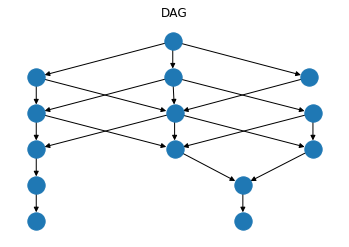

[3,  1000] loss - (total : 2.892663, clf : 0.149857, support : 1.162086, recon : 0.077472, latent : 1.085248), acc - (clf : 0.968750, recon : 0.975000)
[3,  1200] loss - (total : 2.995813, clf : 0.142784, support : 1.164049, recon : 0.113306, latent : 1.142216), acc - (clf : 1.000000, recon : 0.943750)
[ Eval ] loss - (total : 3.252865, clf : 0.318375, support : 1.163036, recon : 0.236528, latent : 1.097319), acc - (clf : 0.915194, support : 0.560071, recon : 0.918905)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 3, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 46, 17]
comp.sys.mac.hardware : [5, 23, 11, 46, 17]
comp.windows.x : [5, 23, 11, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 3, 17]
sci.electronics : [5, 36, 14, 46, 17]
-----
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
alt.atheism : [42, 23, 44, 10, 24]
rec.autos : [4

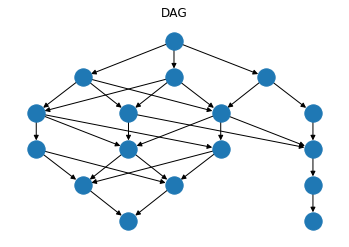

[4,  1400] loss - (total : 2.637537, clf : 0.192585, support : 0.995129, recon : 0.263980, latent : 0.728037), acc - (clf : 0.968750, recon : 0.925000)
[ Eval ] loss - (total : 2.716943, clf : 0.313575, support : 0.922692, recon : 0.191663, latent : 0.847644), acc - (clf : 0.907244, support : 0.663428, recon : 0.938163)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 3, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.sys.mac.hardware : [5, 36, 11, 46, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 11, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-----
alt.atheism : [42, 23, 44, 10, 24]
rec.autos : [42, 36, 15, 46, 17]
sci.med : [42, 23, 11, 46, 17]
soc.religion.christian : [42, 23, 44, 10, 24]
talk.

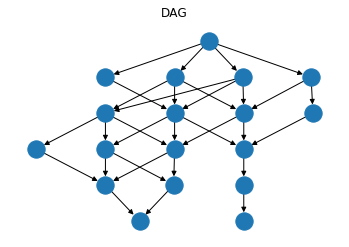

[5,  1600] loss - (total : 1.867612, clf : 0.028926, support : 0.712810, recon : 0.093012, latent : 0.590311), acc - (clf : 1.000000, recon : 0.950000)
[5,  1800] loss - (total : 1.297463, clf : 0.018496, support : 0.458981, recon : 0.058538, latent : 0.356849), acc - (clf : 1.000000, recon : 0.981250)
[ Eval ] loss - (total : 2.647893, clf : 0.315658, support : 0.905043, recon : 0.129455, latent : 0.909123), acc - (clf : 0.912544, support : 0.690813, recon : 0.962014)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.autos : [20, 36, 39, 46, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
talk.politics.m

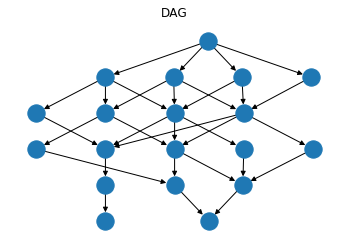

[6,  2000] loss - (total : 1.045659, clf : 0.004962, support : 0.375121, recon : 0.014741, latent : 0.271035), acc - (clf : 1.000000, recon : 0.987500)
[6,  2200] loss - (total : 0.992949, clf : 0.007225, support : 0.331614, recon : 0.072222, latent : 0.234914), acc - (clf : 1.000000, recon : 0.975000)
[ Eval ] loss - (total : 2.565803, clf : 0.324254, support : 0.877697, recon : 0.147296, latent : 0.871117), acc - (clf : 0.914311, support : 0.704064, recon : 0.968375)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
---

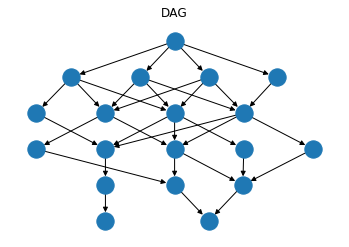

[7,  2400] loss - (total : 1.482404, clf : 0.035859, support : 0.507694, recon : 0.039874, latent : 0.568670), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.560028, clf : 0.341896, support : 0.897378, recon : 0.093902, latent : 0.911410), acc - (clf : 0.910777, support : 0.699647, recon : 0.981272)
comp.graphics : [5, 23, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
soc.religion.christian : [20, 23, 44, 10, 24]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-----
alt.atheism : [42, 23, 44, 10, 24]
comp.os.ms-windows.misc : [42, 36, 11, 46, 17]
rec.autos : [42, 36, 39, 46, 17]
sci.med : [42, 23, 11, 46, 17]
tal

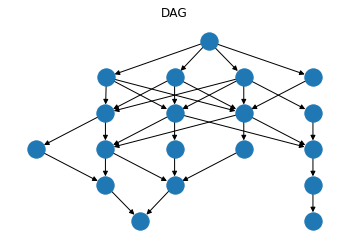

[8,  2600] loss - (total : 1.442321, clf : 0.020526, support : 0.530124, recon : 0.005084, latent : 0.579537), acc - (clf : 1.000000, recon : 1.000000)
[8,  2800] loss - (total : 1.006098, clf : 0.002025, support : 0.383854, recon : 0.002467, latent : 0.326085), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.569677, clf : 0.357912, support : 0.882740, recon : 0.098990, latent : 0.947704), acc - (clf : 0.909011, support : 0.704947, recon : 0.981979)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
soc.religion.christian : [20, 23, 44, 10, 24]
-----
ta

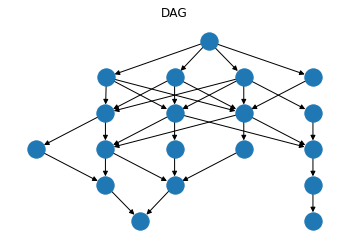


Finetuning hierarchical layers

[9,  3000] loss - (total : 0.747181, clf : 0.001378, support : 0.268517, recon : 0.002075, latent : 0.191789), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.557436, clf : 0.359209, support : 0.907522, recon : 0.097038, latent : 0.910021), acc - (clf : 0.909894, support : 0.697880, recon : 0.983039)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-----
alt.atheism : [42, 23, 44, 10, 24]
rec.autos : [42, 36, 39, 46, 17]
sci.med : [42, 23, 11, 46, 17]
soc.religion.chri

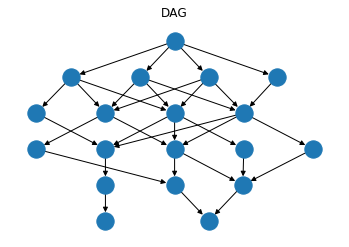

[10,  3200] loss - (total : 1.200479, clf : 0.000844, support : 0.468119, recon : 0.038975, latent : 0.399974), acc - (clf : 1.000000, recon : 0.993750)
[10,  3400] loss - (total : 0.806374, clf : 0.001417, support : 0.303757, recon : 0.002952, latent : 0.213335), acc - (clf : 1.000000, recon : 0.993750)
[ Eval ] loss - (total : 2.807934, clf : 0.359209, support : 0.913256, recon : 0.168678, latent : 1.080362), acc - (clf : 0.909894, support : 0.707597, recon : 0.971731)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-

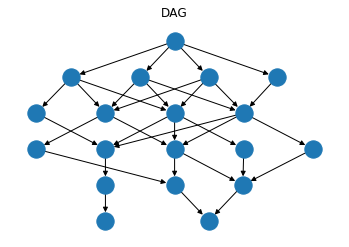

[11,  3600] loss - (total : 0.693633, clf : 0.001121, support : 0.246916, recon : 0.002268, latent : 0.156199), acc - (clf : 1.000000, recon : 1.000000)
[11,  3800] loss - (total : 1.137766, clf : 0.004631, support : 0.360288, recon : 0.049910, latent : 0.430867), acc - (clf : 1.000000, recon : 0.981250)
[ Eval ] loss - (total : 2.518557, clf : 0.359209, support : 0.869573, recon : 0.090551, latent : 0.906435), acc - (clf : 0.909894, support : 0.760601, recon : 0.981272)
comp.graphics : [5, 23, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
soc.religion.christian : [20, 23, 44, 10, 24]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-

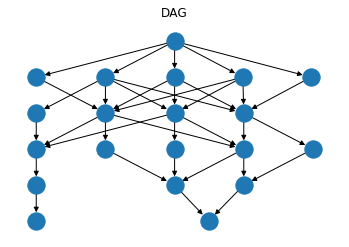

[12,  4000] loss - (total : 0.736667, clf : 0.001687, support : 0.247047, recon : 0.003673, latent : 0.188043), acc - (clf : 1.000000, recon : 1.000000)
[ Eval ] loss - (total : 2.677784, clf : 0.359209, support : 0.895805, recon : 0.130475, latent : 0.993396), acc - (clf : 0.909894, support : 0.741166, recon : 0.977562)
comp.graphics : [5, 23, 11, 46, 17]
comp.os.ms-windows.misc : [5, 36, 11, 46, 17]
comp.sys.ibm.pc.hardware : [5, 36, 11, 3, 17]
comp.windows.x : [5, 23, 15, 3, 17]
misc.forsale : [5, 14, 14, 3, 17]
rec.motorcycles : [5, 36, 39, 46, 17]
sci.electronics : [5, 14, 11, 46, 17]
-----
comp.sys.mac.hardware : [20, 36, 11, 3, 17]
rec.sport.baseball : [20, 14, 44, 10, 24]
rec.sport.hockey : [20, 15, 44, 10, 24]
sci.crypt : [20, 14, 44, 10, 24]
sci.space : [20, 14, 11, 46, 17]
soc.religion.christian : [20, 23, 44, 10, 24]
-----
talk.politics.mideast : [40, 23, 44, 10, 24]
-----
alt.atheism : [42, 23, 44, 10, 24]
rec.autos : [42, 36, 39, 46, 17]
sci.med : [42, 23, 11, 46, 17]
tal

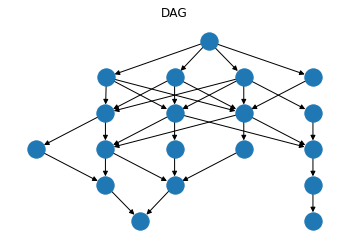

[13,  4200] loss - (total : 0.722781, clf : 0.000615, support : 0.245209, recon : 0.014069, latent : 0.166965), acc - (clf : 1.000000, recon : 0.993750)


KeyboardInterrupt: 

In [5]:
model.fit(data['train']['features'], data['train']['flat_labels']) #, save_dir='train_results/cifar100')